# Training Models

## Imports

### Modules

In [1]:
import numpy as np
import pandas as pd

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Reshape, Concatenate, MaxPooling2D as MP,\
RandomFlip, RandomRotation, RandomCrop, RandomTranslation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

### Loading Images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
fl = np.load('/content/drive/MyDrive/images.npz')
imgs = fl['imgs']
ids = fl['ids']

In [ ]:
def normalise_imgs(imgs, setting=3):
    """
    A normalisation function, with several settings.
    Default is to normalise each object to the brightest pixel in the brightest band
        This erases brightness information but preserves colour information
    """
    import numpy as np
    if setting==0:
        # Global normalisation to the range [0,1]
        nimgs = imgs - np.min(imgs) # Now lowest value is 0, max is like 1e5
        nimgs /= np.max(nimgs) # Now in range [0,1]

    elif setting==1: # Bandwise normalisation
        nimgs = imgs / np.max(imgs, axis=(0,1,2))

    elif setting==2: # Gaussian normalisation
        nimgs = imgs - np.mean(imgs, axis=0) # Subtracting 'mean' object
        nimgs /= np.std(nimgs, axis=0) # Dividing by 'std' object

    elif setting==3: # Object-wise normalisation
        nimgs = imgs / np.max(imgs, axis=(1,2,3))[:,np.newaxis,np.newaxis,np.newaxis]
    
    return nimgs

---
## Training Model

### Model Architecture

In [ ]:
# Augmentor
def load_augmentor(translate_px=2):
    input_images = Input(shape=(28,28,5), name='img_input')
    x = RandomCrop(24,24, name='cropper')(input_images)
    x = RandomFlip(name='flipper')(x)
    x = RandomTranslation(translate_px/24, translate_px/24,
                        fill_mode='wrap',
                        name='translator')(x)
    augmented_images = RandomRotation(.5, name='rotator')(x)
    augmentor = Model(input_images, augmented_images,
                    name='augmentor')
    return augmentor

# Encoder Base, with inputs randomly cropped to shape (24,24,5)
def load_encoder():
    augmented_images = Input(shape=(24,24,5), name='augmented_input')
    x = Conv2D(256, 5, activation='relu',
            name='Conv2D_0')(augmented_images)
    x = MP(pool_size=2)(x)
    x = Conv2D(512, 3, activation='relu',
            name='Conv2D_1')(x)
    x = MP(pool_size=2)(x)
    x = Conv2D(1024, 3, activation='relu',
            name='Conv2D_2')(x)
    x = MP(pool_size=2)(x)
    features = Reshape((1024,),
                    name='Reshape')(x)
    encoder = Model(augmented_images, features,
                name='encoder')
    return encoder

# Projection Head
def load_projector():
    features = Input(shape=(1024,), name='features')
    x = Dense(512, activation='relu',
            name='Dense_0')(features)
    x = Dense(128, activation='relu',
            name='Dense_1')(x)
    projection = Dense(64,
                    name='Dense_2')(x)
    projector = Model(features, projection,
                    name='projector')
    return projector

### Loss Function

In [ ]:
@tf.function
def boltz_matrix(normed_mini_batch, temp=1):
    """
    An intermediate step in calculating the loss for a given batch
    Inputs: A mini-batch of (normalised) vectors z_i
            A temperature parameter, default=1
    Output: A matrix with the values B_ij = exp(sim(z_i, z_j)/temp) if i!=j, 0 if i==j.
                This matrix has the shape (2*batch_size, 2*batch_size)
    """
    raw_bm =  tf.math.exp(
        tf.linalg.matmul(normed_mini_batch, normed_mini_batch, transpose_b=True) / temp
    ) # exp(sim(z_i, z_j)/temp) forall i, j
    return tf.linalg.set_diag(raw_bm, tf.zeros_like(normed_mini_batch[:,0])) # zeroing out where i==j

@tf.function
def contrastive_loss(mini_batch, temp=1): # Minibatch(i) has shape (batch_size*2, projection_dim)
    """
    Calculates contrastive loss for a given mini-batch
    Inputs: A mini-batch of N-dimensional vectors output by the projector of the CNN
            A temperature parameter, default=1
    Output: The scalar contrastive loss for that mini-batch
    """
    batch_size = tf.shape(mini_batch)[0] // 2 # Should be even anyway
    normed_mini_batch, _ = tf.linalg.normalize(mini_batch, axis=1) # Loss only needs angles
    boltz_mat = boltz_matrix(normed_mini_batch, temp=temp)
    positive_boltzs = tf.linalg.diag_part(tf.roll(boltz_mat,batch_size, 0)) # Positive samples
    boltz_norms = tf.math.reduce_sum(boltz_mat, axis=0)
    return tf.math.reduce_mean(
        -tf.math.log(tf.math.divide(positive_boltzs, boltz_norms))
    )

### Contrastive Model Class

In [ ]:
class Contrastor(Model):
    def __init__(self, augmentor, encoder, projector, temperature=1, **kwargs):
        super().__init__(**kwargs)
        self.augmentor=augmentor
        self.encoder=encoder
        self.projector=projector
        self.loss_tracker = tf.keras.metrics.Mean(name='contrastive loss')
        self.temperature = temperature

    @property
    def metrics(self):
        return [self.loss_tracker]
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Forward Pass
            projection1 = self.projector(self.encoder(self.augmentor(data)))
            projection2 = self.projector(self.encoder(self.augmentor(data)))
            mini_batch = Concatenate(axis=0)([projection1, projection2])
            
            cl = contrastive_loss(mini_batch, temp=self.temperature)

        grads = tape.gradient(cl, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.loss_tracker.update_state(cl)
        return{'loss': self.loss_tracker.result()}

In [ ]:
grizY_contr = Contrastor(
    load_augmentor(),
    load_encoder(),
    load_projector(),
    temperature=.015
)
grizY_contr.compile(
    optimizer=optimizers.SGD(
        learning_rate=1e-4,
        momentum=1e-4),
    run_eagerly=True
)

history = grizY_contr.fit(
    normalise_imgs(imgs),
    batch_size=128,
    callbacks = [
        EarlyStopping(
            monitor='loss',
            mode='min',
            patience=5,
            verbose=1
        )
    ]
)

---
## Evaluation

In [ ]:
grizY_enc = grizY_contr.encoder # Encoder of above trained model

# Forward passing the original images
encoded_imgs = grizY_enc(
    normalise_imgs(imgs[:,2:-2,2:-2,:])
    ).numpy()
encoded_imgs = np.array([enc_img / np.linalg.norm(enc_img) for enc_img in encoded_imgs])

In [ ]:
embedding = umap.UMAP().fit(encoded_imgs)
points = embedding.embedding_
np.savez_compressed('./gdrive/MyDrive/embedding.npz',
                    points = embedding.embedding_,
                    ids=ids)

The embedding reveals several clusters, of which one is of particular interest: the tiny cluster just west of the major continent, nicknamed "Sylt". There are 12 objects here, of which 8 are known (spectroscopically confirmed) high-redshift quasars

In [2]:
import matplotlib.pyplot as plt
fl = np.load('./embedding.npz')
ids = fl['ids']
points = fl['points']
x = points[:,0]
y = points[:,1]

(4.5, 6.0)

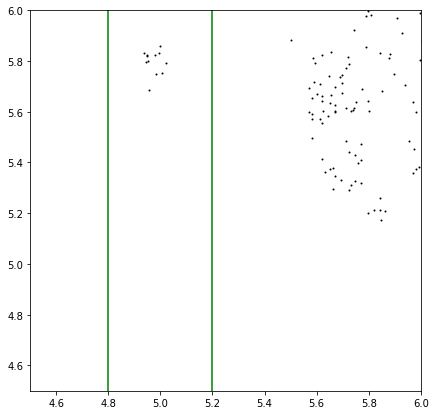

In [17]:
fg, ax = plt.subplots(figsize=(7,7))
ax.scatter(x,y,
            s=1,
            c='k'
           )
isin_sylt = (x>4.8)&(x<5.2)
ax.axvline(4.8, c='g')
ax.axvline(5.2, c='g')
ax.set_xlim([4.5,6])
ax.set_ylim([4.5,6])

In [20]:
objs_of_interest = ids[isin_sylt]
np.savez_compressed('./sylt_ids.npz',
                    ids=objs_of_interest)